# Notebook 1: Cats vs. Dogs (D1) Dataset Preparation 

This notebook will follow several steps to download and explore the cats vs. dogs TensorFlow dataset, with the aim of inspecting the dataset, cleaning it, and preparing it for training a deep learning Generative Adversarial Network (GAN) image sharpening model. The neccessary operations will first be identified before adding these to an extract transform and load (ETL) pipeline that will transform data before sending it to the GAN model. This is necessary due to the large dataset size, as operating on the full dataset will cause the cloud notebook environment to crash due to RAM memory limitations. 

The GAN model will be trained to sharpen images that are 32x32 pixels in size, resulting in sharpened images of 128x128 pixels in size, i.e. a 4x increase. Therefore for training, the GAN requires low and high resolution image pairs, of 32x32 and 128x128 pixels, of the same image. After training, the GAN can learn how to sharpen unseen 32x32 pixel resolution images. 
To create these training image pairs, any images greater than 128x128 pixels in the cats vs dogs dataset will need to be downsized and any images under this size will need to be removed from the dataset. Following that, a second lower resolution 32x32 pixel version of the 128x128 pixel images will be created, giving the low resolution (LR) and high resolution (HR) image pairs required for training the GAN. 

## 1. Import Required Libraries

In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## 2. Download Dataset 
Firstly the cats vs dogs dataset will be downloaded into the notebook environment.

In [2]:
# Update the URL attribute to the updated correct URL to download the dataset:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',
"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

cats_vs_dogs_a = tfds.load("cats_vs_dogs", as_supervised=True) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


The dataset is downloaded as a TensorFlow dataset and the images and associated labels it will be converted into an 2-dimensionsal numpy array in the next cell. The full image dataset has 23,262 images, which will be inspected for their suitabiliy for training the image sharpening GAN in the next section.

# 3. Exploratoty Data Analysis (EDA)
The downloaded cats vs. dogs TensorFlow dataset will be explored to determine its suitability for training the GAN and inspected for any images that need to be modified or removed.

In [3]:
images_labels = []
for image,label in (tfds.as_numpy(cats_vs_dogs_a["train"])):
    images_labels.append((image,label))

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


In [4]:
# Print the total number of images in the downloaded dataset:
print("Total number of images:", len(images_labels))

Total number of images: 23262


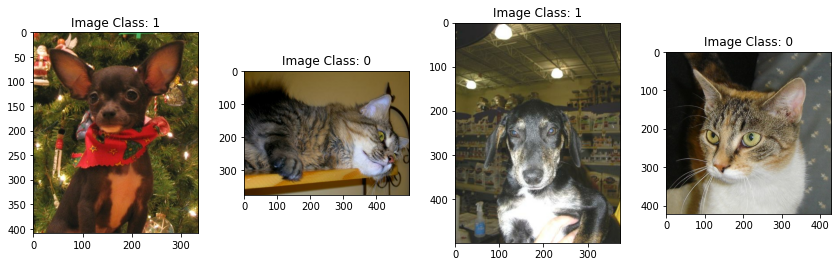

In [5]:
#Plot several images for illustrative purposes:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,8))
plt.subplot(1, 4, 1) 
plt.imshow(images_labels[1][0])
plt.title("Image Class: {}".format(images_labels[2][1]))

#Plot a second image:
plt.subplot(1, 4, 2) 
plt.imshow(images_labels[3][0])
plt.title("Image Class: {}".format(images_labels[3][1]))

#Plot a third image:
plt.subplot(1, 4, 3) 
plt.imshow(images_labels[9][0])
plt.title("Image Class: {}".format(images_labels[9][1]))

#Plot a fourth image:
plt.subplot(1, 4, 4) 
plt.imshow(images_labels[15][0])
plt.title("Image Class: {}".format(images_labels[15][1]))

plt.tight_layout(pad=2)
plt.show()

From the 4 sample images plotted in the cell above, it is clear that class 0 corresponds to a cat image and class 1 corresponds to a dog image. Also, it is worth noting that the images are of variable pixel dimensions across the dataset, based on this small sample. Next, the range of values for each pixel will be investigated, as deep learning models perform best with data that lies in a range between 0 and 1. 

## 3.1 Inspect Pixel Values

In [6]:
# Find the pixel value range:
print("Minimum pixel value of Image 1:", images_labels[1][0].min())
print("Maximum pixel value of Image 1:",images_labels[1][0].max())

print("--------------------")
# Check another image:
print("Minimum pixel value of Image 8:", images_labels[8][0].min())
print("Maximum pixel value of Image 8:",images_labels[8][0].max())

print("--------------------")
print("dtype of each pixel:", images_labels[8][0].dtype)

Minimum pixel value of Image 1: 0
Maximum pixel value of Image 1: 255
--------------------
Minimum pixel value of Image 8: 2
Maximum pixel value of Image 8: 255
--------------------
dtype of each pixel: uint8


From the output of the above cell it can be seen that the pixel values for the images are in the range of between 0 and 255 for each pixel. Neural Networks can be trained more efficiently if image pixel data normalised so it falls in the range of between 0 and 1. This pixel value transformation will be performed in the next cell for a sample of images from the full dataset. Once verified, this step will be added to the data input pipeline.

In [7]:
# Normalise the pixel values of each image so they fall in the range of 0 - 1 for 10 test images:
images_labels_norm = []
for i in range(0,10):
    image_label = (images_labels[i][0].astype(float)/255.0, images_labels[i][1])
    images_labels_norm.append(image_label)

In [8]:
# Find the pixel value range:
print("Minimum pixel value of Image 1:", images_labels_norm[1][0].min())
print("Maximum pixel value of Image 1:",images_labels_norm[1][0].max())

print("--------------------")
# Check another image:
print("Minimum pixel value of Image 8:", images_labels_norm[8][0].min())
print("Maximum pixel value of Image 8:",images_labels_norm[8][0].max())

print("--------------------")
print("dtype of each pixel:", images_labels_norm[8][0].dtype)

Minimum pixel value of Image 1: 0.0
Maximum pixel value of Image 1: 1.0
--------------------
Minimum pixel value of Image 8: 0.00784313725490196
Maximum pixel value of Image 8: 1.0
--------------------
dtype of each pixel: float64


The code two cells above converts the image pixels to a floating point value and then divides by 255 to scale the pixel values to lie between 0 and 1. However, this operation, if done on the entire dataset, increases the required memory in the cloud computing environment to greter than the limit of 30GB RAM, so the notebook crashes. This is why only a small sample of the dataset is being transformed here, while the full dataset will undergo this pixel value transformation as part of the ETL process while passing the data into the GAN for training.

In [9]:
from sys import getsizeof
# Print out the number of memory Bytes the variables require befoer and after converting to floating point:
print(len(images_labels[:10]), "Images using", getsizeof(images_labels[:10]), 
      "Bytes ({})".format(images_labels[0][0].dtype))
print(len(images_labels_norm), "Images using", getsizeof(images_labels_norm), 
      "Bytes ({})".format(images_labels_norm[0][0].dtype))

10 Images using 152 Bytes (uint8)
10 Images using 200 Bytes (float64)


From the output of the cell above, it can be seen that converting the images from Uint8 format to floating point format, causes an increase in memory usage of about 30%. This is why the cloud notbook environment is crashing if the full dataset of over 23,000 images is converted to floating point values and then stored in RAM. 

In [10]:
# Find the pixel value range after normalising a sample set of the images:
print("Minimum pixel value of image 1:", images_labels_norm[1][0].min())
print("Maximum pixel value of image 1:",images_labels_norm[1][0].max())

# Check another image:
print("Minimum pixel value of image 8:", images_labels_norm[8][0].min())
print("Maximum pixel value of image 8:",images_labels_norm[8][0].max())

Minimum pixel value of image 1: 0.0
Maximum pixel value of image 1: 1.0
Minimum pixel value of image 8: 0.00784313725490196
Maximum pixel value of image 8: 1.0


It can be seen from the output of the above cell that the pixel values in the 10 transformed images now have pixel values that fall between 0 and 1. This will be done on every image in the image dataset that will be used for training the GAN model during the extract transform and load (ETL) pipeline for bringing data to the model.

Next, the full image dataset will be explored for any undersized images that are smaller in either width or length than 128 pixels.

## 3.2 Image Dimensions
For training the image sharpening GAN to sharpen 32x32 pixel images to 128x128 pixel images, images in this training dataset will need to be a minimum of 128x128 pixels.

In [11]:
# Create a pandas dataframe to more easily display and filter the image data:
df = pd.DataFrame(columns=["L_Px","W_Px","Channels", "Label"])

for i in range(len(images_labels)):
    df.loc[i] = [int(images_labels[i][0].shape[0]),images_labels[i][0].shape[1],
                 images_labels[i][0].shape[2],
                 images_labels[i][1]]
df

,L_Px,W_Px,Channels,Label
0,262,350,3,1
1,409,336,3,1
2,493,500,3,1
3,375,500,3,0
4,240,320,3,1
...,...,...,...,...
23257,397,500,3,0
23258,375,500,3,0
23259,375,500,3,0
23260,500,434,3,1


In [12]:
# Print out some metrics from the full dataframe relating to the pixel size:
print("L_Px Max:", df["L_Px"].max())
print("W_Px Max:", df["W_Px"].max())
print("L_Px Min:", df["L_Px"].min())
print("W_Px Min:", df["W_Px"].min())

L_Px Max: 500
W_Px Max: 500
L_Px Min: 4
W_Px Min: 4


From the output of the above cell it can be seen that that the maximum lengh and width of the images are both 500 pixels. Interestingly, the minimum length and width pixel values are each 4 pixels, which indicates that this dataset will have to be cleaned to remove small images under 128x128 pixels. In the next cell, the pandas dataframe containing the image attributes will be searched to identify undersized images.

In [13]:
# Show a subset of the smaller images in the dataset to see the pixel dimensions:
small_px = df["W_Px"].min() + 40 

# Filter the dataset for smaller images using a lambda function:
df[df["W_Px"].apply(lambda x: x<=small_px) | df["L_Px"].apply(lambda x: x<=small_px)]

,L_Px,W_Px,Channels,Label
10388,39,60,3,1
10530,36,60,3,0
12970,41,60,3,0
13685,4,4,3,0
19858,37,100,3,1
21346,33,60,3,0


It can be seen from the output of the above cell that there is an image of 4x4 pixels in size and the next smallest image is 33x60 px in size. It would be interesting to visualise these images before eliminating them.

Image Class: 0


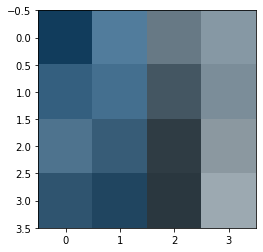

In [14]:
# Plot image pixels:
plt.imshow(images_labels[13685][0])
print("Image Class:", images_labels[13685][1])

From the plot in the above cell, it is clear that this image should not be in the dataset and it will be removed. It does not depict a cat (class 0) as the label states.

Image Class: 0


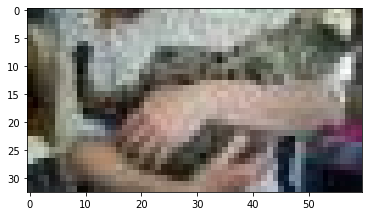

In [15]:
# Plot image pixels:
plt.imshow(images_labels[21346][0])
print("Image Class:", images_labels[21346][1])

The image in the above cell is the second smallest image in the dataset and it is very pixelated due to its low resolution. All images with either a width or length dimension of less than 128 pixels will be removed from the dataset as part of data cleaning, as these are not suitable for training the GAN.

In [16]:
# Find undersized images by filtering the dataframe:
undersized_images_df = df.loc[(df["L_Px"]<128) | (df["W_Px"]<128)]

# Save a list of the index of each undersize image in the dataset:
indices_to_remove = undersized_images_df.index.values
indices_to_remove[:20]

array([  5,  82,  98, 140, 224, 241, 267, 270, 365, 401, 410, 421, 577,
       578, 637, 647, 702, 780, 814, 823])

The indices of images that are undersized in the dataset are found in the above cell. 

In the next cell, a new dataframe will be created that will contain a copy of the undersized images, so that these can be investigated.

In [17]:
# Create a new dataframe for the undersized images:
relegated_df = pd.DataFrame(columns=["L_Px","W_Px","Channels", "Label", "Old Index"])

# Add the original index as an additional column in the dataframe for reference:
for i,j in enumerate(indices_to_remove):
    relegated_df.loc[i] = undersized_images_df.loc[j]
    relegated_df["Old Index"][i] = j

relegated_df

,L_Px,W_Px,Channels,Label,Old Index
0,100,100,3,1,5
1,118,126,3,1,82
2,120,160,3,0,98
3,120,160,3,1,140
4,129,125,3,0,224
...,...,...,...,...,...
457,100,100,3,0,22657
458,98,160,3,0,22805
459,133,82,3,0,22914
460,59,90,3,0,22960


It can be seen from the output of the above cell that the dataframe of undersized images contains 462 rows, indicating that 462 images have either a length or width dimension of less than the required 128 pixels. In the next cell, these images will be removed, leaving a dataframe with only images above or equal to the minimum pixel size. 

In [18]:
# Firstly deep copy the original dataframe to preserve it from being modified:
filtered_df = df.copy(deep=True)

# Remove the entries from the dataframe where the pixels do not meet the minimum size:
filtered_df = filtered_df.drop(indices_to_remove)
filtered_df

,L_Px,W_Px,Channels,Label
0,262,350,3,1
1,409,336,3,1
2,493,500,3,1
3,375,500,3,0
4,240,320,3,1
...,...,...,...,...
23257,397,500,3,0
23258,375,500,3,0
23259,375,500,3,0
23260,500,434,3,1


It can be seen from the output of the above cell that the cleaned dataframe contains 22,800 entries, which would correspond to 22,800 valid images for training the GAN. In the next cell, the minimum and maximum pixel measurements will be calculated on the new dataframe to verify that the removal of undersized images was successful.

In [19]:
# Print out some metrics from the cleaned dataframe relating to the pixel size:
print("L_Px Max:", filtered_df["L_Px"].max())
print("W_Px Max:", filtered_df["W_Px"].max())
print("L_Px Min:", filtered_df["L_Px"].min())
print("W_Px Min:", filtered_df["W_Px"].min())


L_Px Max: 500
W_Px Max: 500
L_Px Min: 128
W_Px Min: 128


From the output of the above cell, it can be seen that the cleaned dataframe now only contains images that are 128 pixels or greater across their length or width, as required for training the GAN.

# 3.3 Class Balancing
The cleaned dataset will be inspected for how many representations exist for each class. Training a neural network on an unbalanced dataset will lead to a biased model, so it is essential that the classes are balanced before training.

In [20]:
# Display the counts of each image class from the cleaned dataframe:
filtered_df.groupby("Label").size()

Label
0    11415
1    11385
dtype: int64

From the output of the cell above, it can be seen that the cleaned dataframe contains unbalanced class representations of cats and dogs, with 11,415 cat images and 11,385 dog images. For image classification applications, classes do need to be balanced, so this is the reason for this step. There are 30 extra cat images that will need to be removed to balance the classes, which will be performed in the next cell.

In [21]:
# Remove the 30 smallest resolution images of cats from the dataset:
cats_removed_df = filtered_df.loc[(filtered_df["Label"]==0)].copy()
image_size_score = cats_removed_df["L_Px"]*cats_removed_df["W_Px"]
cats_removed_df["image_size_score"] = image_size_score
cats_removed_df.sort_values(by='image_size_score', ascending=True)

,L_Px,W_Px,Channels,Label,image_size_score
13683,129,131,3,0,16899
12858,134,128,3,0,17152
14741,140,128,3,0,17920
7531,134,134,3,0,17956
8814,135,135,3,0,18225
...,...,...,...,...,...
4382,500,500,3,0,250000
3044,500,500,3,0,250000
20509,500,500,3,0,250000
19886,500,500,3,0,250000


In the cell above, an image size score feature was created from the cat images, by multiplying the image width pixels by the height pixels. A lower number in this column indicates a smaller image and the smaller images will be removed first, as these images contain less information than images with larger pixel dimensions.

In [22]:
cats_indices_to_remove = cats_removed_df.sort_values(by='image_size_score', ascending=True).index.values[:30]
# Remove these images from the filtered dataframe:
cats_removed_df = cats_removed_df.drop(cats_indices_to_remove)
cats_removed_df.sort_values(by='image_size_score', ascending=True)

,L_Px,W_Px,Channels,Label,image_size_score
13217,146,150,3,0,21900
19449,147,150,3,0,22050
5299,132,170,3,0,22440
7354,150,150,3,0,22500
17519,150,150,3,0,22500
...,...,...,...,...,...
18086,500,500,3,0,250000
2967,500,500,3,0,250000
19202,500,500,3,0,250000
10767,500,500,3,0,250000


In [23]:
# Apply this to the filtered_df dataframe and verify that the classes are now balanced:
filtered_df = filtered_df.drop(cats_indices_to_remove)
# Display the counts of each image class from the cleaned dataframe:
filtered_df.groupby("Label").size()

Label
0    11385
1    11385
dtype: int64

From the output of the above cell, it can be seen that the classes are now balanced in the filtered_df dataframe. Next, both groups of images will be removed from the main image dataset.

## 3.4 Data Input Pipeline 
From the EDA that was carried out, the following preprocessing steps have been identified that will need to be undertake on the downloaded dataset to prepare it for training the GAN: 
1. Firstly, discard images that are under 128x128 pixels in size, using the identified list of indices to remove from the dataset.
2. Secondly, balance the classes in the dataset.
3. Next, downscale all remaining images to 128x128 pixels in size to create the high resolution dataset.
4. Next, downscale all remaining images to 32x32 pixels in size to create the low resolution dataset.
5. Finally, cast image pixel values to floating point values so that they lie in the range of between 0 and 1. This can be done as the data is loaded into the model in batches for training, as this will help to reduce memory requirements.

In [24]:
# Create a single array of all indexed images that need to be removed for undersized images
# and for balancing the classes:
final_indices_to_remove =  np.append(indices_to_remove, cats_indices_to_remove) 
# Sort the array so that the indices are in ascending order:
final_indices_to_remove.sort()
print("Total number of images being removed:", len(final_indices_to_remove))

Total number of images being removed: 492


In [25]:
# This code will remove the undersized images and balance the classes within the full 
# image dataset that currently stored in RAM:
print("No. of images before filtering out undersized images & balancing classes:", len(images_labels))
removed_images = [] # removed images will be kept in a new list for safe keeping.
for i in final_indices_to_remove[::-1]: #This iterates the list in reverse to preserve indexing.
    element = images_labels.pop(i)
    removed_images.insert(0, element) # Insert at start of list to preserve the original index.
print("No. of images after filtering out undersized images & class balancing:", len(images_labels))

No. of images before filtering out undersized images & balancing classes: 23262
No. of images after filtering out undersized images & class balancing: 22770


In [26]:
# Quick verification that the classes are balanced in the processed dataset:
cat_counts = 0
dog_counts = 0
for element in images_labels:
    if element[1] == 0: # element[1] is the image label
        cat_counts+=1
    else:  
        dog_counts+=1
print("No. Cat Images:", cat_counts)
print("No. Dog Images:", dog_counts)

No. Cat Images: 11385
No. Dog Images: 11385


In [30]:
# Quick demonstration that the undersized images were removed successfully:
for i in range(0,10): print(images_labels[i][0].shape, "label:",images_labels[i][1])

(262, 350, 3) label: 1
(409, 336, 3) label: 1
(493, 500, 3) label: 1
(375, 500, 3) label: 0
(240, 320, 3) label: 1
(216, 182, 3) label: 0
(375, 500, 3) label: 0
(377, 500, 3) label: 1
(500, 375, 3) label: 1
(500, 496, 3) label: 1


# 4. Creating the LR (Low Resolution) and HR (High Resolution) Image Pairs 
The cleaned dataset will now be resized into two lower resolution formats, giving the low and high resolution image pairs, which are required for training the image sharpening GAN. One dataset will contain 128x128 pixel images and the second dataset will contain 32x32 pixel images. 

In [31]:
# Create the 32x32 low resolution and 128x128 high resolution cats vs dogsimage pairs:
images_hr = []
images_lr = []
labels = []

#Rescale images so all images are 128x128 pixels and 32x32 pixels, creating the image pairs:
for image,label in images_labels:
    images_hr.append(cv2.resize(image, (128, 128), interpolation = cv2.INTER_AREA)) 
    images_lr.append(cv2.resize(image, (32, 32), interpolation = cv2.INTER_AREA))
    labels.append(label)

# Note: This cell adds 9GB of RAM  

A random sample of 5 of the LR/HR image pairs will be plotted to verify that the images look correct.

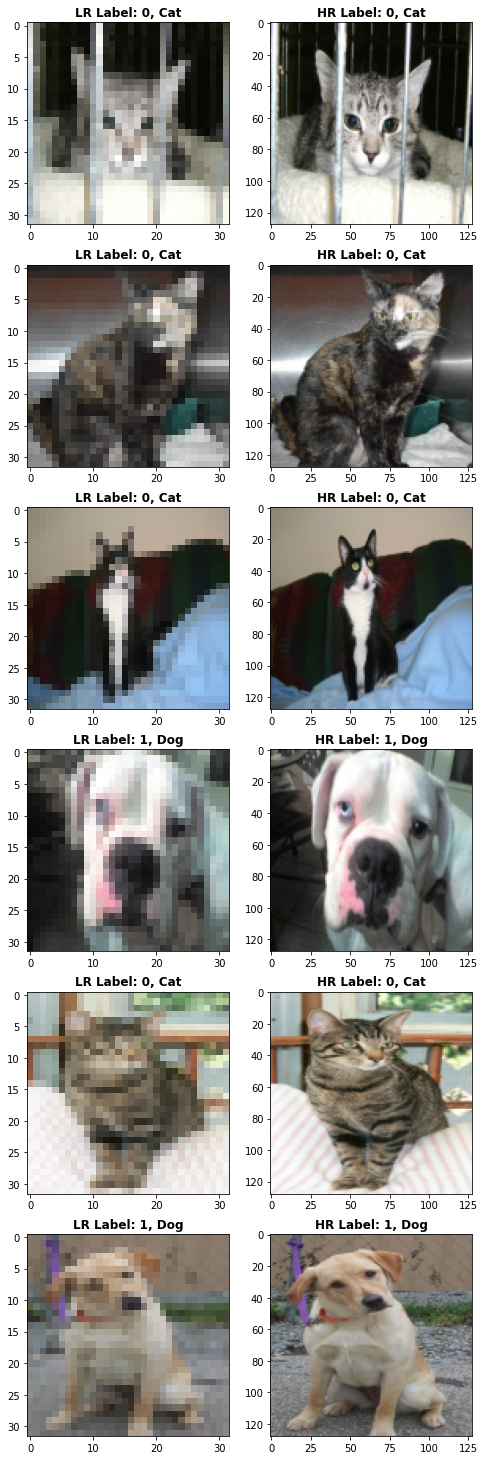

In [78]:
cats_dogs_label_names = {0:"Cat", 1:"Dog"}

# Plot some of the training data and associated labels:   
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(8,26))
np.random.seed(7889)
for image in range(0, 11, 2):
    random_index = int(np.random.randint(low = 1, high = len(images_lr), size = 1))
    plt.subplot(6,2,image+1)
    plt.imshow(images_lr[random_index])
    label = labels[random_index]
    label_text = cats_dogs_label_names[label]
    plt.title("LR Label: {}, {}".format(label, label_text), fontsize=12, fontweight='bold')
    plt.subplot(6,2,image+2)
    plt.imshow(images_hr[random_index])
    plt.title("HR Label: {}, {}".format(label, label_text), fontsize=12, fontweight='bold')

The images in the above cell show a sample of the low resolution (LR) and high resolution (HR) image pairs, along with displaying the image label as the title of each image. 

# 5. Exporting the LR/HR Image Datasets
The cleaned and prepared image datasets will be exported from this notebook environment so they can be used in Notebook 2 for training the image sharpening GAN.

In [ ]:
# Export the image datasets so that they can be used in other environments:
np.savez("images_lr", images_lr)
np.savez("images_hr", images_hr)
np.savez("labels", labels)